In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
# 데이터 불러오기

df = pd.read_csv('/content/drive/MyDrive/github/딥러닝/Pytorch/Supervised Learning/kospi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 23.7+ KB


In [4]:
# Min-Max Normalization

scaler = df.iloc[:, 1:]
df.iloc[:, 1:] = (scaler - scaler.min(axis=0)) / (scaler.max(axis=0) - scaler.min(axis=0))
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.660665,0.656462,0.673942,0.673018,0.673018,0.326694
std,0.162642,0.165504,0.163478,0.161306,0.161306,0.130715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.594537,0.583024,0.607581,0.606183,0.606183,0.222079
50%,0.670789,0.663381,0.686152,0.683206,0.683206,0.306774
75%,0.751404,0.747642,0.764424,0.762323,0.762323,0.408704
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# GPU/CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'CPU')
print(f"{device} is available")

cuda:0 is available


In [6]:
# Dataset
X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

In [7]:
# 시계열 텐서 만들기
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [8]:
# 데이터 배치 형태로 만들기
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [9]:
# 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [10]:
# 모델링
class VanillaRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device =device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로 부터 나온 output feature 반환, hn: hidden state 반환
        out = out.reshape(out.shape[0], -1) # many to many 전략
        out = self.fc(out)
        return out

# 모델 선언
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [11]:
# 손실 함수, 최적화 기법
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# 모델 학습
loss_graph = []
n_batch = len(train_loader)

for epoch in range(200):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data

        optimizer.zero_grad()

        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_graph.append(running_loss/n_batch)
    
    if epoch % 100 == 0:
        print('[epoch: %d] loss:%.3f'%(epoch, running_loss/n_batch))

[epoch: 0] loss:0.021
[epoch: 100] loss:0.001


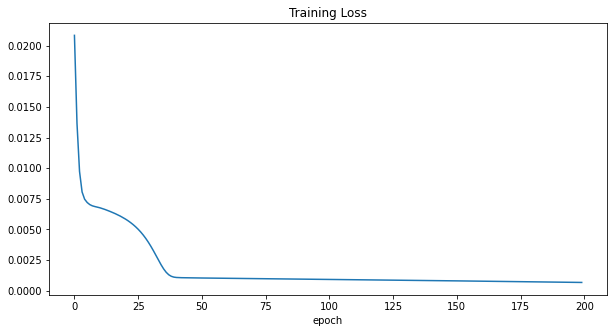

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(loss_graph)
ax.set_title('Training Loss')
ax.set_xlabel('epoch')
plt.show()

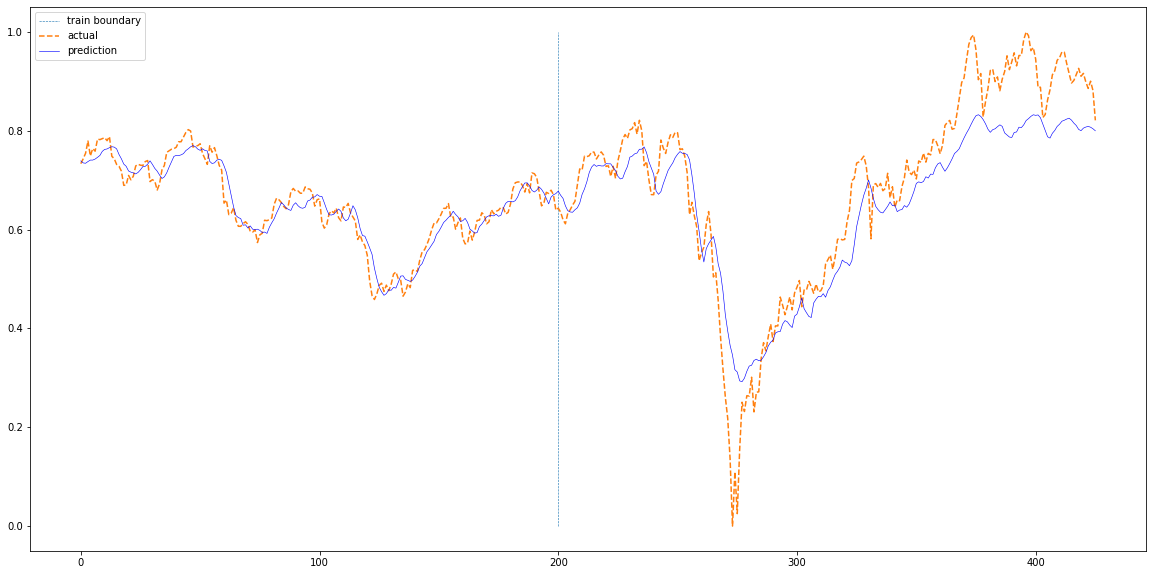

In [14]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        model.eval()
        train_pred = []
        test_pred = []
   
        for data in train_loader:
            seq, target = data # 배치 데이터 
            #print(seq.size())
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()
            
        for data in test_loader:
            seq, target = data # 배치 데이터 
            #print(seq.size())
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
    total = train_pred+test_pred       
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0,1,100),'--', linewidth=0.6)
    plt.plot(actual,'--')
    plt.plot(total,'b', linewidth=0.6)
    
    
    plt.legend(['train boundary','actual','prediction'])
    plt.show() 
    
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)   